# Ejercicio en lineas de frontera (boundary lines): Regresion Logística

## Introducción:

En este ejercicio usted implementarà la regresión logística para dos conjuntos de datos. Antes de comenzar le recomiendo que mires los videos de clase y las notas de clase.

Toda la información que necesita para esta tarea está contenida en este cuaderno, lo mismo que el
código que necesita implementar.

Las librerías (módulos) que necesitará son ```numpy``` y ```matplotlib```.

In [1]:
## Es obligatorio hacer esta parte, de otro modo el final del codigo no correrá.
!pip install numpy==1.21.6


In [2]:
# para el manejo de caminos
import os

# para la parte numérica
import numpy as np

# para gràficas
from matplotlib import pyplot

# optimización
from scipy import optimize

# incluye la gráfica en este cuaderno
%matplotlib inline

In [3]:
print(np.__version__)

1.21.6


## 1 Regresión logística
En esta sección usted debe construir un modelo para decidir si un estudiante es admitido a la unviersidad. Suponga que usted es el jefe de admisiones y registro de la universidad y desea determinar si los aplicantes deben ser admitidos basados en 2 exàmenes. Usted tiene la historia de los datos de los aplicantes de años anteriores, con los cuales puede entrenar su regresión logística. Para cada estudiante usted tiene los resultados de dos exámentes de admisión. Su tarea es construir un modelo de clasificación que estima la probabilidad de admisión basándose en los dos exámenes.

En la siguiente celda se cargan los datos.

In [4]:
# cargar datos
# las primeras dos columnas tienen los resultados de los exámenes
# la tercera contiene las etiquetas
data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

### 1.1 Visualización de los datos

Antes de implementar cualquier tarea de aprendizaje es útil visualizar los datos, siempre que sea posible. Mostramos los datos en gràficos en 2 dimensiones. Debes completar el código en ```plotData``` de forma que los ejes son las calificaciones de los dos exámenes y los resultados (positivo o negativo) se muestran con marcadores.

Para que puedas practicar el software de graficación le dejamos espacio para implementar la función ```plotData```.   Sin embargo esto no lo califico, más abajo incluyo la implementación para que la compare
con su trabajo. Si decides copiar y pegar de mi implementación abajo, asegúrese de aprender los comandos
de ```matplotlib``` y ```numpy```.


```python
# Encuentre los índices de muestras positivas y negativas
pos = y == 1
neg = y == 0

# Grafique los ejemplos
pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
```

In [5]:
def plotData(X, y):
    """
    Grafique los puntos X y y.  Los puntos los debe graficar
    con * para la muestras positivas y o para las muestras negativas.

    Parameters
    ----------
    X : arreglo de floats
        Una matriz  Mx2 que representa los datos.

    y : arreglo de floats
        Datos con las etiquetas. Un vector de tamaño (M, ).

    Instrucciones
    ------------
    Grafique las muestras positivas y negativas en una figura 2D, usando
    la opcion 'k*' para las muestras positivas y 'ko' para las muestras
    negativas.
    """
    # nueva figura
    fig = pyplot.figure()
    pos = y == 1
    neg = y == 0
    # ====================== SU CÒDIGO ACÁ ======================
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

    # ============================================================

Llamemos la funcion para cargar la figura con los datos:

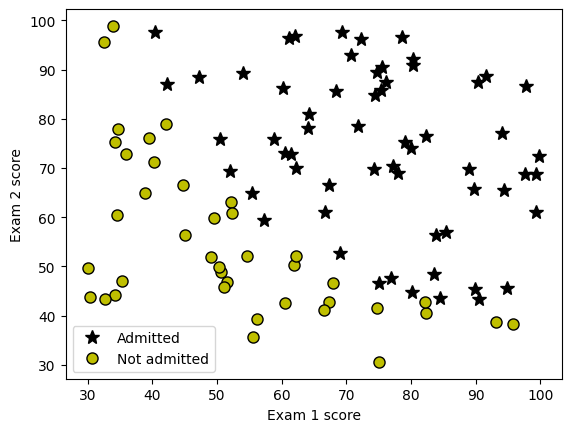

In [6]:
plotData(X, y)
# etiquetas a los ejes
pyplot.xlabel('Exam 1 score')
pyplot.ylabel('Exam 2 score')
pyplot.legend(['Admitted', 'Not admitted'])
pass

<a id="section1"></a>
### 1.2 Implementación

#### 1.2.1 Ejercicio de calentamiento: funciòn sigmoid logística

Recuerde, antes de implementar la función de costo, que la hipótesis se definine como:
$$ h_\theta(x) = g(\theta^T x)$$

donde la funciòn $g$ es la sigmoid logística definida como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Su primer paso es implementar esta función para que se pueda usar en
el resto del programa. Trate de probarla par algunos valores llamando
```sigmodi(x)``` en una nueva celda. Para valores positivos grandes de `x`,
la función sigmoid debería estar cerca a 1, mientras que para valores negativos
grandes debería estar cerca a 0. El valor ```sigmoid(0)``` debería ser
exactamente 0.5. Su código debería trabajar también para vectores y matrices.
**Para el caso en que el argumento sea una matriz, la funciòn sigmoid debe
operar elemento-por-elemento.
<a id="sigmoid"></a>

In [7]:
def sigmoid(z):
    """
    evalue la funcion logístic sigmoid con argumento z

    Parameters
    ----------
    z : arreglo de floats
        Puede ser un vector o una matriz 2D.


    Returns
    -------
    g : arreglo de floats
        Debe tener la misma estructura de z, dado que la
        operación se da elemento-por-elemento.

    Instrucciones:
    ------------
    Calcule la función logística sigmoid para cada valor z
    sea este escalar, vector, o matriz.
    """

    # convierta la entrada en un arreglo en numpy
    z = np.array(z)

    # Necesita retornar las siguientes variables correctamente
    g = np.zeros(z.shape)

    # ====================== SU CÓDIGO ACÀ ======================

    g = 1/(1+np.exp(-z))

    # =============================================================
    return g

La siguiente celda evalúa la función logística sigmoid en ```z=0```. Deberìa obtener 0.5. Puede experimentar
con otros valores de ```z```.

In [8]:
# pruebe su implementación acá.
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


<a id="section2"></a>
#### 1.2.2 Función de costo y su gradiente

A continuación usted debe implementar la función de costo  para la regresión logística.
Antes de seguir non olvide agregar el intercepto X.

In [9]:
# Construya la matriz apropiadamente agregando unos para el intercepto
m, n = X.shape

# Agrega el intercepto
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Ahora debe completar la implementación de la función de costo ```costFunction``` la cual retorna la funciòn de costo y su gradiente. Recuerda que la función de costo para la regresión logística está dada por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente de la función de costo es un vector de la misma longitud de $\theta$ donde la
componente $j$ para $j=0,1, \cdots, n$ se define como


$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note que, aunque este gradiente se ve idèntico la del gradiente de la regresión lineal, la fòrmula
es diferente por que la regresión logística y lineal tienen hipótesis diferentess $h(\theta, x)$.

<a id="costFunction"></a>

In [10]:
def costFunction(theta, X, y):
    """
    calcule la función de costo para la regresión logística

    Parámetros
    ----------
    theta:  arreglo de floats
        Los parámetros de la regresión logística son un vector
        de tamaño (n+1, ).


    X : arreglo de floats
        Los datos de entrada tienen tamaño (n x n +1 ) donde m es
        el nùmero de puntos de entrada y n es el número de atributos.
        Se asume que el intercepto ya se ha agregado a la matriz de datos.



    y : arreglo de floats
        Las etiquetas para la entrada. El tamaño del vector es (m, ).

    Retorna
    -------
    J : float
        El valor de la funciòn de costo


    grad : arreglo de floats
        Un vector de tamaño (n+1, ) con el gradiente de la función de costo,
        con respecto a theta.

    Instructiones
    ------------
    Compute the cost of a particular choice of theta. You should set J to
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Inicialice algunos valores ùtiles
    m = y.size  # nùmero de muestras de entrenamiento

    # Necesita retornar las siguientes variables correctamente.
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== SU CÓDIGO ACÁ ======================

    h = sigmoid(np.dot(X, theta))

    # Calcula la función de costo
    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

    # Calcula el gradiente
    grad = (1 / m) * np.dot(X.T, (h - y))

    # =============================================================
    return J, grad

Una vez termine debe llamar su ```costFunction``` usando dos pruebas para $\theta$
en la próxima celda.

In [11]:
# inicialice los parámetros
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# calcule y muestre la función de costo y el gradiente con theta no nulo
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


#### 1.2.3 parámetros de aprendizaje metiante el uso de`scipy.optimize`
En una tarea anterior usted encontró los parámetros óptimos de un modelo
de regresión lineal mediante el uso del descenso con gradiente. Usted escribió la
función de costo y calculó el gradiente, luego usó el gradiente para bajar al mínimo.
En este caso, en vez de usar los pasos de descenso de gradiente, usted usará
el módulo [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una librería numérica de `python`. Esta provee un módulo
de optimización para encontrar una raíz mediante optimización. En  `scipy 1.0`, la función `scipy.optimize.minimize` es el método de optimizacion para problemas con o sin restricciones.

Para el caso de regresión logística, usted debe optimizar la función de costo
 $J(\theta)$ con parámetros $\theta$. Concretamente, usted debe usar la función
  `optimize.minimize` para entrontrar los parámetros  $\theta$ de la regresión
de costo logística dados los datos "X" y "y". Debe pasar a la función  `optimize.minimize` los siguientes parámetros

- `costFunction`: La función de costo , dados los datos de entrenamiento y un $\theta$ particular para los datos (X, y). Es importante notar que solo pasamos el nombre de la función sin paréntesis. Esto indica que solo pasamos una referencia a la función, y no  el resultado de su evaluación.

- `initial_theta`:  El valor inicial de los parámetros de optimización

- `(X, y)`: Estos son argumentos adicionales para a función de costo.

- `jac`: Un indicador de si la función retorna el Jacobiano (gradiente) junto con el valor de costo (True)


- `method`: Método de optimización que usa el algoritmo.

- `options`: opciones adicionales las cuales pueden ser esfecíficas al método de optimización. En lo que sigue solo le decimos al algoritmo el máximo número de iteraciones que se pueden ejecutar.

If ya completó la  `costFunction` correctamente , `optimize.minimize` dbe converger
a los parámetros adecuados de optimización y retornar los valores finales de la
función de costo lo mismo que $\theta$.   Note que mediante el uso  `optimize.minimize`, usted evita la escritura de ciclos, o definir una tasa de aprendizaje como lo hace para el descenso con gradiente. Esto lo hacer el
`optimize.minimize`: usted solo necesita suministrar una función que calcula el costo y su gradiente.

Enseguida tenemos el codigo escrito que llama  `optimize.minimize` con los argumentos
correctos.

In [12]:
# limitar el número de iteraciones a 400
options= {'maxiter': 400}

# consulte la documentación de scipy en optimize.minimize para la descripción
# de los diferentes parámetros.
# a función retorna un objeto  `OptimizeResult`

# Usamos un algoritmo truncado de Newton para lo optimización que
# es equivalente a la función de MATLAB fminunc
# ver  https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)


# la propiedad de la función  `OptimizeResult` retorna
# el valor de la costFunction para el valor optimizado de theta
cost = res.fun

# el valor óptimo de theta esta en la propiedad "x"
theta = res.x

# imprima theta
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')


Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


<ipython-input-12-81cbd18df572>:11: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,


Una vez la función  `optimize.minimize` finalice, debemos usar el valor final de $\theta$ para visualizar la frontera de decisión en los datos de entrenamiento
como se muestra en a siguiente Figura.

![](Figures/decision_boundary1.png)

Pare esto escribimos la función `plotDecisionBoundary` que grafica la frontera
de decisión. Sugerimos que revisen el código `plotDecisionBoundary` para ver como
se grafica esta frontera usando los valores de  $\theta$. Esta función la encontrará en `utils.py` que viene con esta tarea.

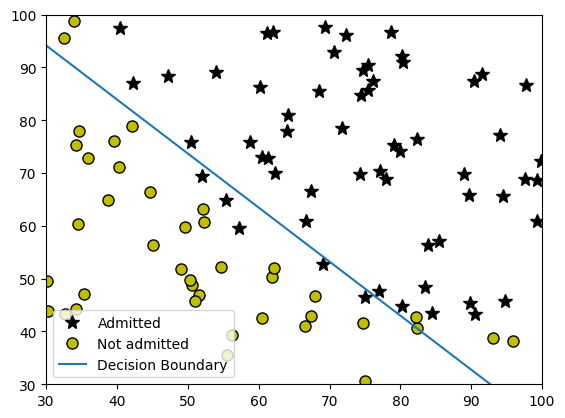

In [13]:
# Grafique la frontera de decisión
import utils
utils.plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logística.

Luego de aprender los parámetros, usted puede usar el modelo para predecir si algún alumno puede o no ser admitido. Para un estudiante con una nota de 45 en el primer
examen y 85 en el segundo examen, debe encontrar una probabilidad de admisión de 0.776. Otra forma de evaluar la calidad de los parámetros que encontró es observando que tan bien el modelo aprendido predice los datos de entrenamiento.
En esta parte, su tarea es completr el código de la función `predict`. Esta función
predice "1" o "0" dados los datos y el parámetro de aprendizaje $\theta$.


<a id="predict"></a>

In [14]:
def predict(theta, X):
    """
    predicción de las etiquetas 0 o 1 usando el modelo aprendido.
    Calcula las predicciones para X usando un umbral de 0.5
    (es decir, si sigmoid(theta.T*x)  >= 0.5, prediga 1)


    Parámetros
    ----------
    theta : arreglo de floats
        Parámetros para la regresión logística. Un vector de tamaño (n+1,).

    X : arreglo de floats
        Los datos usados para hacer la predicción. Las filas son el número
        de puntos (datos), las columnas son el número de atributos (features).

    Retorna
    -------
    p : arreglo de floats
        Predicciones 0 o 1 para cada fila de X.

    Instrucciones
    ------------
    Complete el código a continuación para calcular las predicciones usando
    los parámetros de regresión logística aprendidos. El vector p debe ser
    de 0's y 1's.
    """
    m = X.shape[0] # Número de muestras de entrenamiento

    # debe retornar los valores a continuación correctamente.
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================



    p = (sigmoid(np.dot(X, theta)) >= 0.5).astype(int)

    # ============================================================
    return p

Luego de completar el código en `predict`, procedemos a reportar el "accuracy" de su
clasificador mediante el porcentaje de puntos correctamente predichos.

In [15]:
# Predicción de la probabilidad para un estudiante con nota 45
# en el primer examen y 85 en el segundo.

prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))
print('Expected value: 0.775 +/- 0.002\n')

# calculo del "accuracy" en los datos de entrenamiento.
p = predict(theta, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')

For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


## 2 Regresión logística regularizada

En esta parte de su tarea usted implementará la regresi{on loística regularizada para
predecir si los microchips de una planta de fabricación pasan el control de calidad (Quality Assurance QA). Durante el QA, cada microchip pasa varios estados que aseguran su funcionamiento correcto.

Asuma que su gerente de producción y usted tienen los resultados de la pruebas para algunos microchips
en dos conjuntos.  De estos dos conjuntos de pruebas usted debe determinar si los microchips deberían
ser aceptados o rechazados. Para ayudarle en la decisión, usted tiene un conjunto de datos del pasado, sobre los cuales debe construir su modelo de regresión logística.

Comience por cargar el archivo CSV.


In [16]:
# Cargue los datos
# las dos primeras columnas contienen los valores de X
# la tercera columna tiene los valores de y

data = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

### 2.1 Visualización de los datos
De la misma forma que en los ejercicios previos, la función `plotData` se usa para generar la figura,
donde los ejes son las dos calificaciones, y los valores positivos (y=1, aceptado) y
negativo (y=0, rechazado) se muestran con marcas.

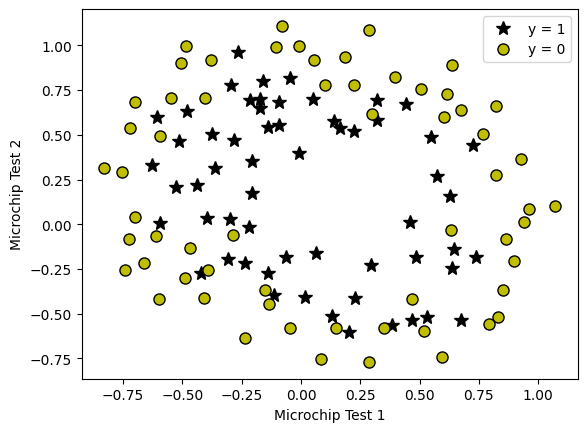

In [17]:
plotData(X, y)
# etiquetas y leyenda
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')

# especificados en orden
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

La figura de arriba muestra que nuestro conjunto no puede ser separado en muestras positivas y negativas por una línea recta.  De esta forma, una aplicación directa y simple de regresión logística no funciona.
Necesitamos un argumento de la hipótesis no lineal.


### 2.2 Mapeo de atributos (feature mapping)
Una forma mejor para ajustar los datos es mediante el uso de atributos para cada punto.
En la función  `mapFeature` definida en el archivo  `utils.py`  mapea los atributos en polinomios
en 2 variables hasta el grado 6.


$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

Como resultado de este mapeo, nuestro vector de dos atributos (los resultados de las dos pruebas de QA) se transforman en un vector de 28 dimensiones. Una clasificación logística entrenada en este espacio de altas dimensiones produce una frontera de decisión más compleja y aparece como no lineal en una gráfica 2-dimensional.

Mientras que este mapeo permite construir clasificadores mas costosos, es mas sensible a sobreajuste.
En lo que sigue del ejercicio usted implementará la regresión logística regularizada para ajustar
los datos y verificar visualmente como la regularización ayuda a combatir el problema de sobreajuste.

In [18]:
# Note que mapFeature agrega la columna de unos que se encarga del intercepto
X = utils.mapFeature(X[:, 0], X[:, 1])
X

array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
       [ 1.00000000e+00,  6.32650000e-01, -3.06120000e-02, ...,
         3.51474517e-07, -1.70067777e-08,  8.22905998e-10]])

<a id="section5"></a>
### 2.3 Función de costo y su gradiente
Ahora usted implementará la parte del código que calcula la función de costo y su gradiente para una regresión logística regularizada.

Recuerde que la función de costo para la regresión logística regularizada está dada por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note que usted no necesita regularizar el parámetro $\theta_0$. El gradiente de la función de
costo es un vector donde el elemento $j$-ésimo está definido como:


$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

In [19]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Calcule el costo  y su gradiente para la regresión logística regularizada.

    Parámetros
    ----------
    theta : arreglo de floats
        Parámetros de la regresión logística. Un vector de tamaño (n, ).
        n es el número de atributos (features) incluyendo el intercepto.
        Si ya mapeamos los atributos a un polinomio, entonfes n es el total
        de atributos (términos) en el polinomio.


    X : arreglo de floats
        Los datos tienen tamaño (m x n). m es el número de muestras, y
        n es el número de atributos (luego del mapeo).


    y : arreglo de floats
        Las etiquetas de los datos. Un vector de tamaño (m, ).

    lambda_ : float
        Parámetro de regularización.

    Returna
    -------
    J : float
        función de costo regularizada

    grad : vector de floats
        Un vector de tamaño (n, ) con el gradiente de la función de costo
        regularizada con respecto a theta, en el valor corriente de theta.
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instrucciones
    ------------
    Calcule el costo "J" para un valor particular de theta.
    Calcule las derivadas parciales que conforman el gradiente
    "grad" para cada parámetro theta.

    """

    # Inicialización de valores
    m = y.size  # número de muestras de entrenamiento

    # necesita retornar las dos variables a continuación correctamente
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== SU CÓDIGO ACÁ ======================

    h = sigmoid(np.dot(X, theta))

    # Calcula el término de regularización (excepto para theta[0])
    regularization_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)


    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) + regularization_term

    # Calcula el gradiente de la función de costo regularizada
    grad = (1 / m) * np.dot(X.T, (h - y))
    grad[1:] += (lambda_ / m) * theta[1:]

    # =============================================================
    return J, grad

Una vez usted complete la función de costo  `costFunctionReg`, la debe llamar abajo usando valores iniciales de $\theta$ de puros unos.

In [20]:
# inicialice los parámetros
initial_theta = np.zeros(X.shape[1])

# asigne 1 a lambda
# no use "lambda" como una variable en python
# por que es una palabra clave
lambda_ = 1

# calcule y muestre la función de costo y su gradiente para la
# regresión logística regularizada
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Calcule y muestre el costo y su gradiente
# con theta todos unos y lambda=10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at test theta - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at test theta - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


#### 2.3.1 Aprendizaje de parámetros usando `scipy.optimize.minimize`

Similarmente, usted debe usar `optimize.minimize` para aprender los parámetros óptimos $\theta$.
Si usted ya completó la función de costo y su gradiente para la regresión logística regularizada
(`costFunctionReg`) correctamente, usted debería ser capaz de resolver la parte siguiente para
aprender $\theta$ usando  `optimize.minimize`.

In [26]:
# inicialice los parametros
initial_theta = np.zeros(X.shape[1])

# use lambda=1 para esta pruebta
lambda_ = 1.00

# opciones para el optimizador
options= {'maxiter': 400}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# el OptimizeResult retorna el valor de la funcion de
# costo para un valor de theta optimizado
cost = res.fun

# el valor optimizado de theta
theta = res.x
theta


<ipython-input-26-a97fd071faba>:10: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,


array([ 1.27271026,  0.62529965,  1.18111686, -2.01987399, -0.91743189,
       -1.43166927,  0.12393228, -0.36553118, -0.35725403, -0.17516291,
       -1.45817009, -0.05098417, -0.61558553, -0.27469165, -1.19271299,
       -0.24217841, -0.20603298, -0.04466179, -0.27778951, -0.29539514,
       -0.45645981, -1.04319154,  0.02779373, -0.29244871,  0.01555761,
       -0.32742405, -0.1438915 , -0.92467487])

### 2.4 Grafique la frontera de decisión.

Para ayudarle a visualizar su modelo aprendido por este clasificador, le
suminstramos la función  `plotDecisionBoundary` la cual grafica la frontera
de decisión no lineal, que separa los puntos aceptados y=1 de los no
aceptados y=0.


/content/utils.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(out)


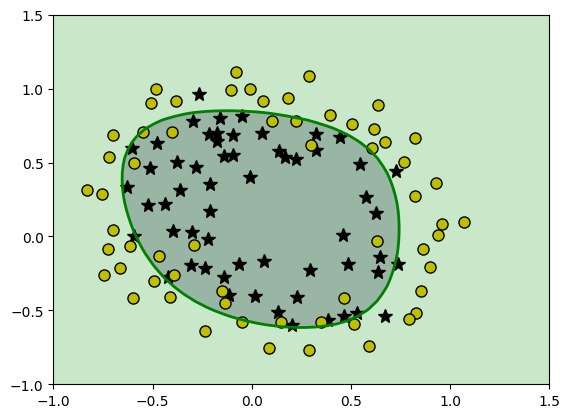

In [27]:
utils.plotDecisionBoundary(plotData, theta, X, y)

### 2.5 Optional no se califica

En esta parte del ejercicio usted debe tratar varios parametros de regularización
para ver como la regularizacion previene el "overfitting"

Note los cambios en la frontera de decisión a medida que varía $\lambda$. Con
un $\lambda$ pequeño debe observar que el calsificator de ajusta a casi todas
las muestras de entrenamiento, pero dibuja una frontera complicada, con sobreajuste (overfitting) a los datos. Observe las siguientes figuras para valores diferentes
de $\lambda$.


<table>
    <tr>
        <td style="text-align:center">
            No regularization (overfitting)<img src="Figures/decision_boundary3.png">
        </td>        
        <td style="text-align:center">
            Decision boundary with regularization
            <img src="Figures/decision_boundary2.png">
        </td>
        <td style="text-align:center">
            Decision boundary with too much regularization
            <img src="Figures/decision_boundary4.png">
        </td>        
    <tr>
</table>

No hay una buena frontera de decision: por ejemplo, sse predice que el punto
 $x = (−0.25, 1.5)$  se acepta $(y=1)$, lo que parece incorrecto para los datos
 de entrenamiento. Con valores de $\lambda$ mayores debería ver una gráfica con
 una frontera de decisión más simple que separa los positivos de los negativos más o menos bien. Sin embargo, si $\lambda$ se usa con un valor muy grande, no se tiene
 un buen ajuste en la frontera de decisición y produce sub-ajuste (underfitting).



In [36]:
# inicialice los parametros
initial_theta = np.zeros(X.shape[1])

# use lambda=1 para esta pruebta
lambda_ = 0.00

# opciones para el optimizador
def overfitting(lambda_):
  options= {'maxiter': 400}

  res = optimize.minimize(costFunctionReg,
                          initial_theta,
                          (X, y, lambda_),
                          jac=True,
                          method='TNC',
                          options=options)

  # el OptimizeResult retorna el valor de la funcion de
  # costo para un valor de theta optimizado
  cost = res.fun

  # el valor optimizado de theta
  theta = res.x

  utils.plotDecisionBoundary(plotData, theta, X, y)
  pyplot.xlabel('Microchip Test 1')
  pyplot.ylabel('Microchip Test 2')
  pyplot.legend(['y = 1', 'y = 0'])
  pyplot.grid(False)
  pyplot.title('lambda = %0.2f' % lambda_)
  pyplot.show()
  # calcule la precision
  p = predict(theta, X)

  print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
  print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')

<ipython-input-36-a100d806f0e0>:11: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,


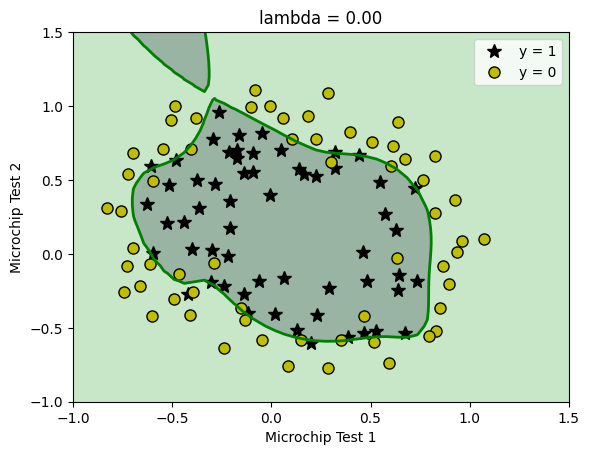

Train Accuracy: 87.3 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



In [37]:
overfitting(0)


<ipython-input-36-a100d806f0e0>:11: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,


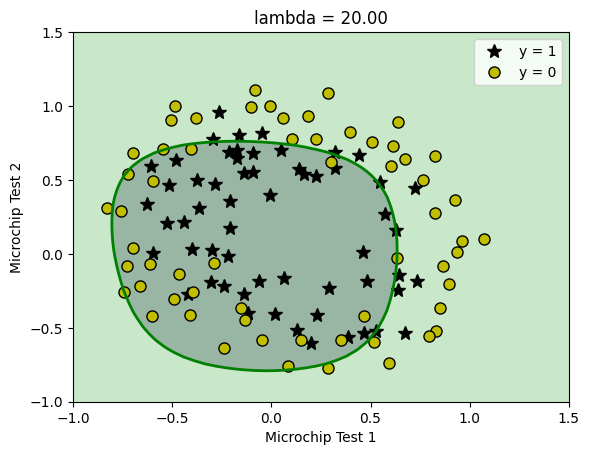

Train Accuracy: 68.6 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



In [42]:
overfitting(20)

<ipython-input-36-a100d806f0e0>:11: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,
/content/utils.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(out)


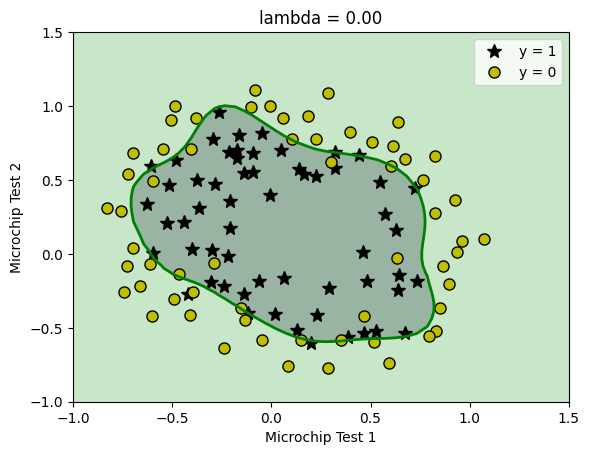

Train Accuracy: 87.3 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



In [48]:
overfitting(1e-9)

<ipython-input-36-a100d806f0e0>:11: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,


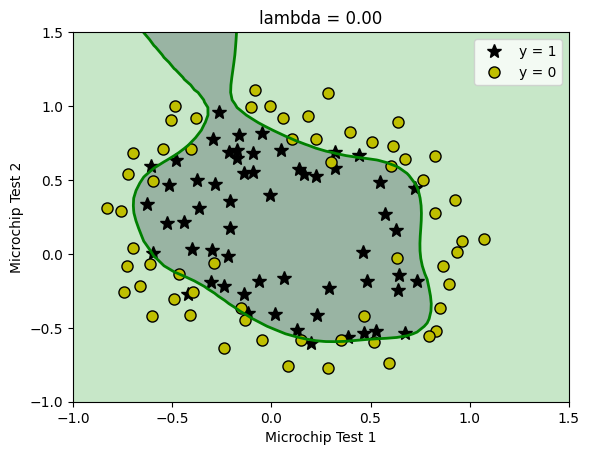

Train Accuracy: 87.3 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



In [49]:
overfitting(1e-5)